# Zillow Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

## Business Problem

A real estate investment firm is interested in knowing the top five best New Jersey zip codes to invest in based on return on investment (ROI) and risk.  

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

## Data Preprocessing

In [5]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    #print(non_dt_cols)
    #print(dt_cols)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [6]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Reshape from Wide to Long Format

In [8]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
#Updated dataframe
melted_df = melt_data(df)
melted_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  int64         
 2   City        object        
 3   State       object        
 4   Metro       object        
 5   CountyName  object        
 6   SizeRank    int64         
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


## Seperate New Jersey Data

In [12]:
#Select NJ data for analysis
nj_df = melted_df[melted_df['State'] == 'NJ']
nj_df.set_index('time', inplace=True)

In [13]:
nj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133030 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    133030 non-null  int64  
 1   RegionName  133030 non-null  int64  
 2   City        133030 non-null  object 
 3   State       133030 non-null  object 
 4   Metro       133030 non-null  object 
 5   CountyName  133030 non-null  object 
 6   SizeRank    133030 non-null  int64  
 7   value       133030 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 9.1+ MB


In [14]:
#Change columns from int64 to string
nj_df['RegionID'] = nj_df['RegionID'].astype(str)
nj_df['RegionName'] = nj_df['RegionName'].astype(str)
nj_df['SizeRank'] = nj_df['SizeRank'].astype(str)

<ipython-input-14-6473a729fe09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nj_df['RegionID'] = nj_df['RegionID'].astype(str)
<ipython-input-14-6473a729fe09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nj_df['RegionName'] = nj_df['RegionName'].astype(str)
<ipython-input-14-6473a729fe09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


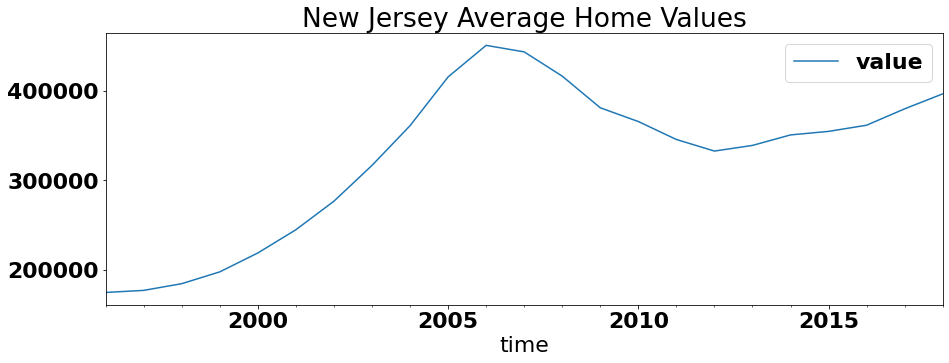

In [16]:
#Plot NJ average home values
nj_df.resample(rule='A').mean().plot(figsize=(15,5))
plt.title('New Jersey Average Home Values');

In [62]:
#Resample NJ data into yearly average
nj_df.resample(rule='A').mean()

,value
time,
1996-12-31,174862.239929
1997-12-31,177175.514608
1998-12-31,184681.308101
1999-12-31,197897.675963
2000-12-31,219015.454847
2001-12-31,244981.557105
2002-12-31,276909.130146
2003-12-31,316903.336653
2004-12-31,361307.719124


In [68]:
#Calculate NJ Return on Investment (ROI) from 1996-2018
 
def ROI(cost, value):
    ROI = (value-cost)/cost
    print(ROI)   

In [81]:
ROI(174862, 393831)

1.2522389083963354


 - Overall New Jersey ROI from 1996 through 2018 was 125%.

## Seperate Data into Individual Counties

In [17]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['CountyName'].unique()

array(['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
       'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer',
       'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren',
       'Hunterdon', 'Cape May', 'Sussex', 'Salem'], dtype=object)

### Hudson County Analysis

In [18]:
hudson_df = nj_df[(nj_df['CountyName'] == 'Hudson')]
hudson_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0
1996-04-01,60599,7093,West New York,NJ,New York,Hudson,215,131700.0
1996-04-01,60594,7087,Union City,NJ,New York,Hudson,320,127300.0


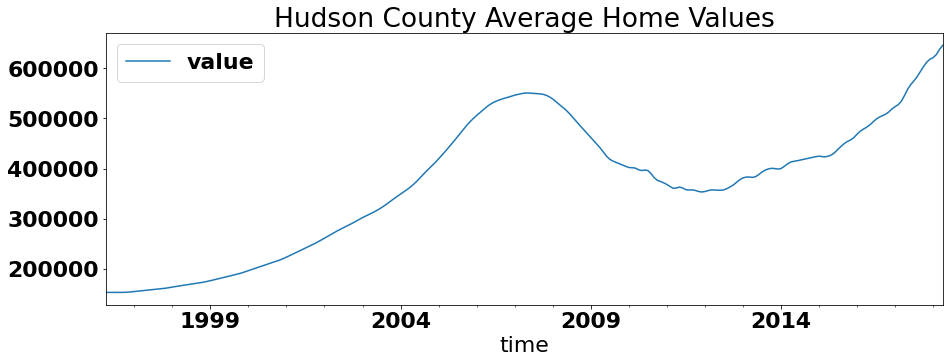

In [51]:
hudson_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Hudson County Average Home Values');

In [56]:
#Resample Hudson County data into yearly average
hudson_yearly = hudson_df.resample(rule='A').mean()
hudson_yearly

,value
time,
1996-12-31,152799.145299
1997-12-31,158035.256410
1998-12-31,168750.000000
1999-12-31,184584.615385
2000-12-31,207874.358974
2001-12-31,239814.102564
2002-12-31,280024.358974
2003-12-31,321571.153846
2004-12-31,378737.820513


In [70]:
ROI(152799, 633382)

3.145197285322548


 - Hudson County ROI from 1996 through 2018 was 315%.

### Ocean County Analysis

In [19]:
ocean_df = nj_df[(nj_df['CountyName'] == 'Ocean')]
ocean_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,61175,8759,Manchester,NJ,New York,Ocean,529,100900.0
1996-04-01,61093,8527,Jackson,NJ,New York,Ocean,569,151000.0
1996-04-01,61173,8757,Berkeley,NJ,New York,Ocean,1069,93200.0


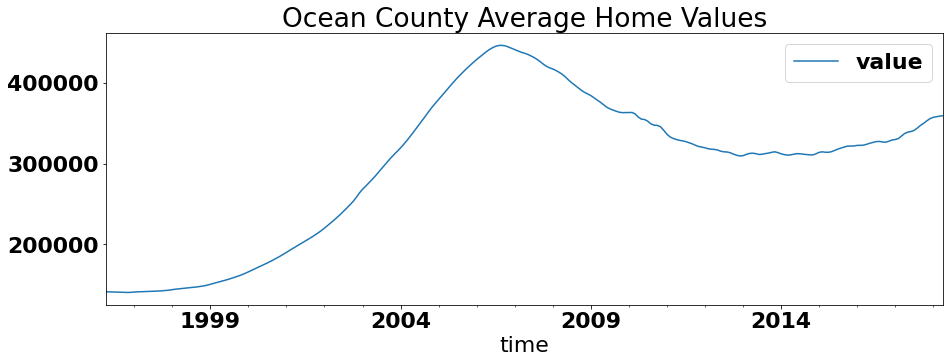

In [52]:
ocean_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Ocean County Average Home Values');

In [57]:
#Resample Ocean County data into yearly average
ocean_yearly = ocean_df.resample(rule='A').mean()
ocean_yearly

,value
time,
1996-12-31,140976.628352
1997-12-31,142119.540230
1998-12-31,146608.333333
1999-12-31,156990.229885
2000-12-31,176511.494253
2001-12-31,203352.298851
2002-12-31,240060.632184
2003-12-31,291663.218391
2004-12-31,346790.517241


### Middlesex County Analysis

In [20]:
middlesex_df = nj_df[(nj_df['CountyName'] == 'Middlesex')]
middlesex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61200,8831,Monroe,NJ,New York,Middlesex,279,218500.0
1996-04-01,61214,8854,Piscataway,NJ,New York,Middlesex,1044,161800.0
1996-04-01,61186,8816,East Brunswick,NJ,New York,Middlesex,1180,196000.0
1996-04-01,61187,8817,Edison,NJ,New York,Middlesex,1412,139200.0
1996-04-01,61219,8861,Perth Amboy,NJ,New York,Middlesex,1675,108000.0


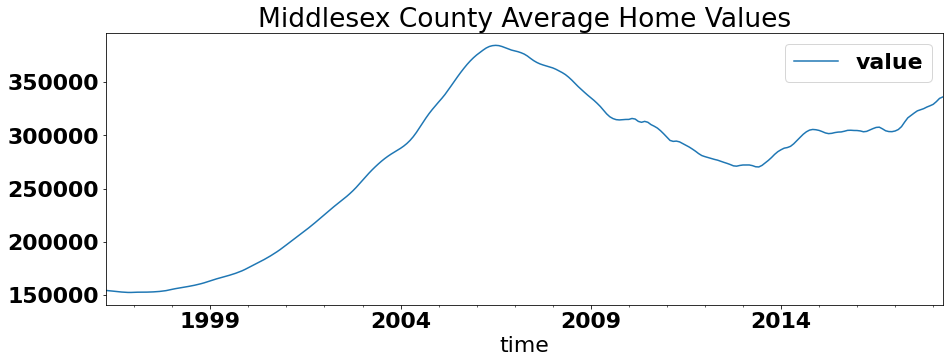

In [53]:
middlesex_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Middlesex County Average Home Values');

In [58]:
#Resample Middlesex County data into yearly average
middlesex_yearly = middlesex_df.resample(rule='A').mean()
middlesex_yearly

,value
time,
1996-12-31,153361.437908
1997-12-31,153315.441176
1998-12-31,158667.156863
1999-12-31,168514.950980
2000-12-31,184768.872549
2001-12-31,209886.274510
2002-12-31,239494.117647
2003-12-31,273566.176471
2004-12-31,306365.931373


### Somerset County Analysis

In [21]:
somerset_df = nj_df[(nj_df['CountyName'] == 'Somerset')]
somerset_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61229,8873,Franklin,NJ,New York,Somerset,550,161100.0
1996-04-01,61208,8844,Hillsborough,NJ,New York,Somerset,1942,227200.0
1996-04-01,61181,8807,Bridgewater,NJ,New York,Somerset,2230,222600.0
1996-04-01,60864,7920,Bernards,NJ,New York,Somerset,4073,354600.0
1996-04-01,61231,8876,Branchburg,NJ,New York,Somerset,4987,177200.0


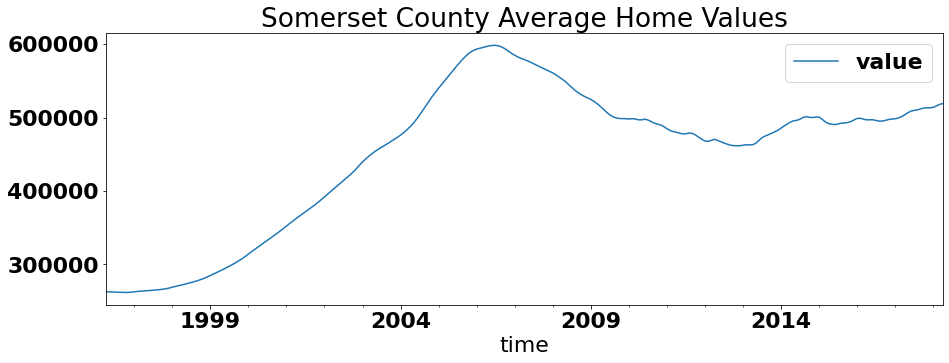

In [54]:
somerset_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Somerset County Average Home Values');

In [59]:
#Resample Somerset County data into yearly average
somerset_yearly = somerset_df.resample(rule='A').mean()
somerset_yearly

,value
time,
1996-12-31,262227.513228
1997-12-31,264880.555556
1998-12-31,275220.634921
1999-12-31,297008.730159
2000-12-31,331385.714286
2001-12-31,370207.142857
2002-12-31,412795.634921
2003-12-31,457599.206349
2004-12-31,502814.682540


### Monmouth County Analysis

In [22]:
monmouth_df = nj_df[(nj_df['CountyName'] == 'Monmouth')]
monmouth_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60776,7728,Freehold,NJ,New York,Monmouth,577,200200.0
1996-04-01,60763,7712,Ocean,NJ,New York,Monmouth,1110,159300.0
1996-04-01,60774,7726,Manalapan,NJ,New York,Monmouth,1499,205700.0
1996-04-01,60793,7753,Neptune,NJ,New York,Monmouth,1704,119400.0
1996-04-01,60786,7740,Long Branch,NJ,New York,Monmouth,2483,116100.0


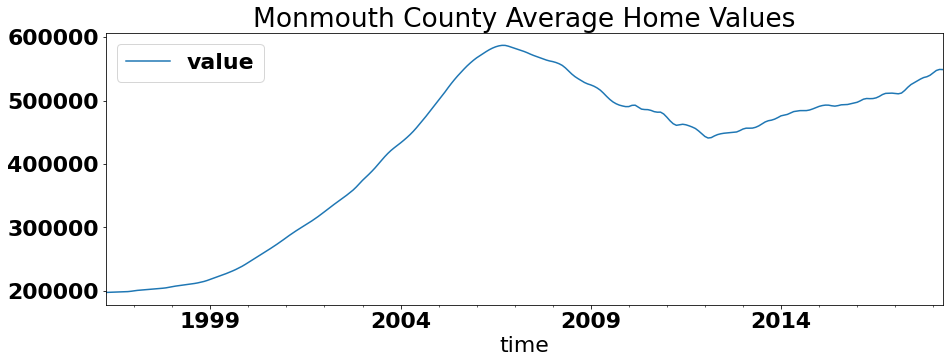

In [60]:
monmouth_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Monmouth County Average Home Values');

In [61]:
#Resample Monmouth County data into yearly average
monmouth_yearly = monmouth_df.resample(rule='A').mean()
monmouth_yearly

,value
time,
1996-12-31,197961.229314
1997-12-31,202424.468085
1998-12-31,210641.134752
1999-12-31,228644.503546
2000-12-31,262084.751773
2001-12-31,302234.042553
2002-12-31,345616.843972
2003-12-31,402376.063830
2004-12-31,461388.297872


### Passaic County Analysis

In [23]:
#Create Passaic County dataframe
passaic_df = nj_df[(nj_df['CountyName'] == 'Passaic')]
passaic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60565,7055,Passaic,NJ,New York,Passaic,623,133100.0
1996-04-01,60688,7470,Wayne,NJ,New York,Passaic,841,240400.0
1996-04-01,60527,7011,Clifton,NJ,New York,Passaic,3129,147600.0
1996-04-01,60529,7013,Clifton,NJ,New York,Passaic,3969,170800.0
1996-04-01,60694,7501,Paterson,NJ,New York,Passaic,4045,105400.0


In [24]:
#Take the mean of each Passaic County value
passaic_average = passaic_df.groupby('time').aggregate({'value':'mean'})
passaic_average

,value
time,
1996-04-01,149352.0
1996-05-01,149192.0
1996-06-01,149036.0
1996-07-01,148872.0
1996-08-01,148736.0
...,...
2017-12-01,286644.0
2018-01-01,289556.0
2018-02-01,293160.0


In [25]:
passaic_yearly = passaic_df.resample(rule='A').mean()
passaic_yearly

,value
time,
1996-12-31,148886.222222
1997-12-31,150718.666667
1998-12-31,154783.000000
1999-12-31,163154.666667
2000-12-31,177700.000000
2001-12-31,196008.000000
2002-12-31,222391.333333
2003-12-31,259125.333333
2004-12-31,297237.000000


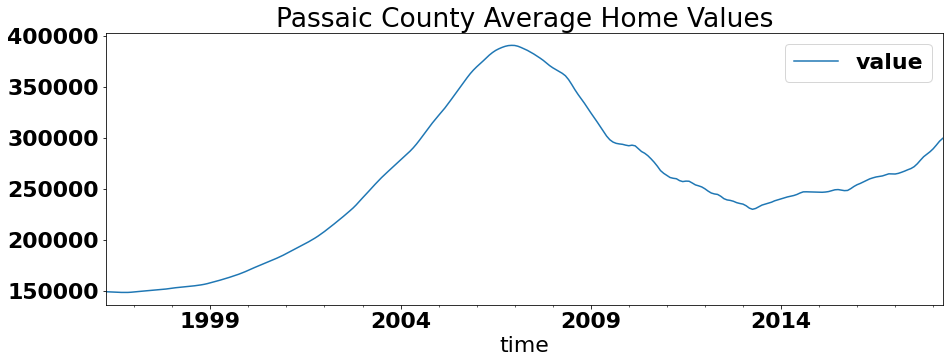

In [26]:
passaic_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Passaic County Average Home Values');

In [27]:
#Check unique cities for Passaic County
passaic_df.City.unique()

array(['Passaic', 'Wayne', 'Clifton', 'Paterson', 'Little Falls',
       'North Haledon', 'Hawthorne', 'West Milford', 'Ringwood',
       'Pompton Lakes', 'Totowa', 'Bloomingdale', 'Wanaque'], dtype=object)

<AxesSubplot:xlabel='time'>

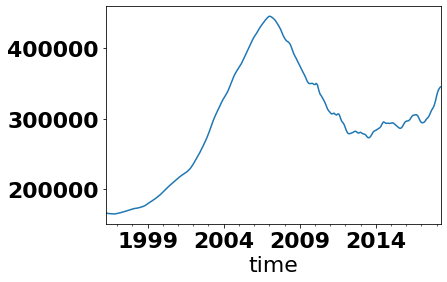

In [28]:
passaic_df.loc[passaic_df['City'] == 'North Haledon']['value'].plot()

<AxesSubplot:xlabel='time'>

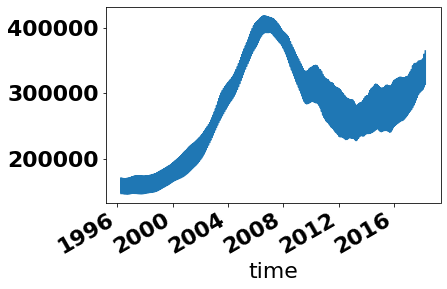

In [29]:
passaic_df.loc[passaic_df['City'] == 'Clifton']['value'].plot() 

### Essex County Analysis

In [30]:
essex_df = nj_df[(nj_df['CountyName'] == 'Essex')]
essex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60519,7003,Bloomfield,NJ,New York,Essex,642,140800.0
1996-04-01,60608,7104,Newark,NJ,New York,Essex,1115,114100.0
1996-04-01,60563,7052,West Orange,NJ,New York,Essex,1171,165300.0
1996-04-01,60609,7105,Newark,NJ,New York,Essex,1797,164500.0
1996-04-01,60613,7109,Belleville,NJ,New York,Essex,2698,123400.0


### Camden County Analysis

In [31]:
camden_df = nj_df[(nj_df['CountyName'] == 'Camden')]
camden_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60916,8021,Lindenwold,NJ,Philadelphia,Camden,679,84800.0
1996-04-01,60971,8081,Winslow,NJ,Philadelphia,Camden,1099,112800.0
1996-04-01,60909,8012,Gloucester,NJ,Philadelphia,Camden,1775,115100.0
1996-04-01,60936,8043,Voorhees,NJ,Philadelphia,Camden,3046,180300.0
1996-04-01,60900,8003,Cherry Hill,NJ,Philadelphia,Camden,3552,170500.0


### Bergen County Analysis

In [32]:
bergen_df = nj_df[(nj_df['CountyName'] == 'Bergen')]
bergen_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60714,7601,Hackensack,NJ,New York,Bergen,833,157500.0
1996-04-01,60540,7024,Fort Lee,NJ,New York,Bergen,948,260200.0
1996-04-01,60750,7666,Teaneck,NJ,New York,Bergen,2344,170800.0
1996-04-01,60656,7410,Fair Lawn,NJ,New York,Bergen,3204,180500.0
1996-04-01,60729,7631,Englewood,NJ,New York,Bergen,3954,163300.0


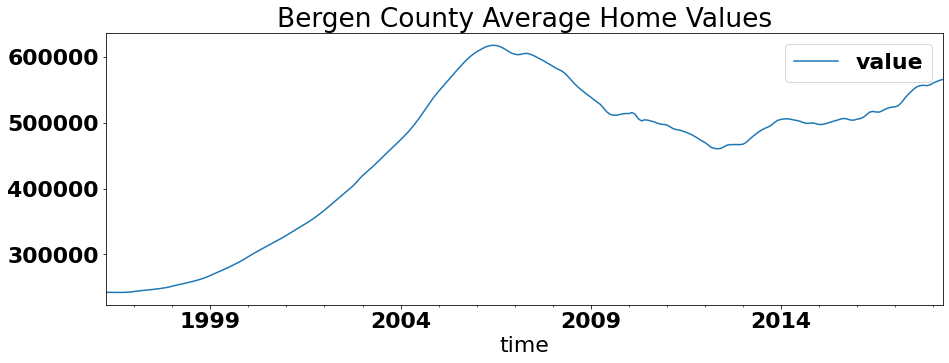

In [33]:
bergen_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Bergen County Average Home Values');

In [34]:
bergen_df.groupby('time').aggregate({'value':'mean'})

,value
time,
1996-04-01,242570.769231
1996-05-01,242533.846154
1996-06-01,242498.461538
1996-07-01,242446.153846
1996-08-01,242430.769231
...,...
2017-12-01,557272.307692
2018-01-01,560176.923077
2018-02-01,562172.307692


In [35]:
bergen_yearly = bergen_df.resample(rule='A').mean()
bergen_yearly

,value
time,
1996-12-31,242617.435897
1997-12-31,246987.435897
1998-12-31,258393.974359
1999-12-31,280335.000000
2000-12-31,311589.743590
2001-12-31,345514.743590
2002-12-31,389926.410256
2003-12-31,444053.846154
2004-12-31,505907.307692


In [36]:
bergen_cities = bergen_df.groupby(['time', 'City']).aggregate({'value':'mean'})
bergen_cities.head()

value
time       City                  
1996-04-01 Allendale     294000.0
           Alpine       1075400.0
           Bergenfield   161100.0
           Bogota        151400.0
           Carlstadt     169800.0

In [37]:
bergen_df.groupby(['time', 'City'])['value'].mean()

time        City          
1996-04-01  Allendale          294000.0
            Alpine            1075400.0
            Bergenfield        161100.0
            Bogota             151400.0
            Carlstadt          169800.0
                                ...    
2018-04-01  Wallington         370300.0
            Washington         506500.0
            Wood Ridge         405700.0
            Woodcliff Lake     739100.0
            Wyckoff            713700.0
Name: value, Length: 17225, dtype: float64

In [38]:
#bergen_cities.resample(rule='A').mean()

### Burlington County Analysis

In [39]:
burlington_df = nj_df[(nj_df['CountyName'] == 'Burlington')]
burlington_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60945,8054,Mt Laurel,NJ,Philadelphia,Burlington,851,158500.0
1996-04-01,60944,8053,Evesham,NJ,Philadelphia,Burlington,917,149400.0
1996-04-01,60912,8016,Burlington,NJ,Philadelphia,Burlington,2893,121100.0
1996-04-01,60938,8046,Willingboro,NJ,Philadelphia,Burlington,3535,89600.0
1996-04-01,60965,8075,Delran,NJ,Philadelphia,Burlington,3550,117400.0


### Union County Analysis

In [40]:
union_df = nj_df[(nj_df['CountyName'] == 'Union')]
union_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60592,7083,Union,NJ,New York,Union,862,152400.0
1996-04-01,60551,7036,Linden,NJ,New York,Union,1582,131700.0
1996-04-01,60569,7060,Plainfield,NJ,New York,Union,2282,126300.0
1996-04-01,60632,7202,Elizabeth,NJ,New York,Union,2350,123000.0
1996-04-01,60574,7065,Rahway,NJ,New York,Union,3396,126400.0


### Mercer County Analysis

In [41]:
mercer_df = nj_df[(nj_df['CountyName'] == 'Mercer')]
mercer_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61100,8540,Princeton,NJ,Trenton,Mercer,989,270200.0
1996-04-01,61129,8618,Trenton,NJ,Trenton,Mercer,2418,74700.0
1996-04-01,61141,8648,Lawrence,NJ,Trenton,Mercer,3098,161000.0
1996-04-01,61127,8610,Hamilton,NJ,Trenton,Mercer,3310,100500.0
1996-04-01,61090,8520,East Windsor,NJ,Trenton,Mercer,3909,139500.0


### Morris County Analysis

In [42]:
morris_df = nj_df[(nj_df['CountyName'] == 'Morris')]
morris_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60884,7960,Morris,NJ,New York,Morris,1281,285900.0
1996-04-01,60564,7054,Parsippany-Troy Hills,NJ,New York,Morris,3444,220700.0
1996-04-01,60848,7869,Randolph,NJ,New York,Morris,4926,253900.0
1996-04-01,60847,7866,Rockaway,NJ,New York,Morris,5332,165800.0
1996-04-01,60806,7801,Dover,NJ,New York,Morris,5527,134200.0


### Atlantic County Analysis

In [43]:
atlantic_df = nj_df[(nj_df['CountyName'] == 'Atlantic')]
atlantic_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61021,8234,Egg Harbor,NJ,Atlantic City,Atlantic,1481,133900.0
1996-04-01,61056,8330,Hamilton,NJ,Atlantic City,Atlantic,3530,103800.0
1996-04-01,61003,8205,Galloway,NJ,Atlantic City,Atlantic,3758,116600.0
1996-04-01,60931,8037,Hammonton,NJ,Atlantic City,Atlantic,4930,97000.0
1996-04-01,61079,8406,Ventnor City,NJ,Atlantic City,Atlantic,6415,119300.0


### Gloucester County Analysis

In [44]:
gloucester_df = nj_df[(nj_df['CountyName'] == 'Gloucester')]
gloucester_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60983,8094,Monroe,NJ,Philadelphia,Gloucester,1745,105600.0
1996-04-01,60985,8096,Deptford,NJ,Philadelphia,Gloucester,2060,99600.0
1996-04-01,60970,8080,Washington,NJ,Philadelphia,Gloucester,2330,140000.0
1996-04-01,60922,8028,Glassboro,NJ,Philadelphia,Gloucester,5606,106100.0
1996-04-01,60974,8085,Woolwich,NJ,Philadelphia,Gloucester,6170,149300.0


### Cumberland County Analysis

In [45]:
cumberland_df = nj_df[(nj_df['CountyName'] == 'Cumberland')]
cumberland_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0
1996-04-01,61036,8302,Bridgeton,NJ,Vineland,Cumberland,2116,75500.0
1996-04-01,61057,8332,Millville,NJ,Vineland,Cumberland,2221,71900.0
1996-04-01,61072,8361,Vineland,NJ,Vineland,Cumberland,6380,113200.0
1996-05-01,61071,8360,Vineland,NJ,Vineland,Cumberland,1779,80000.0


### Warren County Analysis

In [46]:
warren_df = nj_df[(nj_df['CountyName'] == 'Warren')]
warren_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60828,7840,Hackettstown,NJ,Allentown,Warren,2987,154500.0
1996-04-01,61222,8865,Phillipsburg,NJ,Allentown,Warren,3080,98700.0
1996-04-01,60859,7882,Washington,NJ,Allentown,Warren,6995,133700.0
1996-04-01,60814,7825,Blairstown,NJ,Allentown,Warren,9049,171000.0
1996-04-01,60813,7823,Belvidere,NJ,Allentown,Warren,9157,126800.0


### Hunterdon County Analysis

In [47]:
hunterdon_df = nj_df[(nj_df['CountyName'] == 'Hunterdon')]
hunterdon_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61191,8822,Raritan,NJ,New York,Hunterdon,3254,223400.0
1996-04-01,61241,8889,Readington,NJ,New York,Hunterdon,8617,236000.0
1996-04-01,61202,8833,Clinton,NJ,New York,Hunterdon,8917,276400.0
1996-04-01,61095,8530,Lambertville,NJ,New York,Hunterdon,9026,173700.0
1996-04-01,61210,8848,Holland,NJ,New York,Hunterdon,9267,177100.0


### Cape May County Analysis

In [48]:
cape_may_df = nj_df[(nj_df['CountyName'] == 'Cape May')]
cape_may_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,61017,8226,Ocean City,NJ,Ocean City,Cape May,3631,182400.0
1996-04-01,61002,8204,Lower,NJ,Ocean City,Cape May,4537,107700.0
1996-04-01,61004,8210,Middle,NJ,Ocean City,Cape May,5878,93300.0
1996-04-01,61034,8260,North Wildwood,NJ,Ocean City,Cape May,6038,89500.0
1996-04-01,61032,8251,Villas,NJ,Ocean City,Cape May,7399,61800.0


### Susses County Analysis

In [49]:
sussex_df = nj_df[(nj_df['CountyName'] == 'Sussex')]
sussex_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60844,7860,Newton,NJ,New York,Sussex,4412,136300.0
1996-04-01,60850,7871,Sparta,NJ,New York,Sussex,5720,190000.0
1996-04-01,60684,7461,Wantage,NJ,New York,Sussex,6188,137500.0
1996-04-01,60830,7843,Hopatcong,NJ,New York,Sussex,7883,121200.0
1996-04-01,60660,7419,Hardyston,NJ,New York,Sussex,8472,134300.0


### Salem County Analysis

In [50]:
salem_df = nj_df[(nj_df['CountyName'] == 'Salem')]
salem_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60960,8070,Pennsville,NJ,Philadelphia,Salem,7321,90700.0
1996-04-01,60959,8069,Carneys Point,NJ,Philadelphia,Salem,7541,70500.0
1996-04-01,61045,8318,Pittsgrove,NJ,Philadelphia,Salem,7902,89000.0
1996-04-01,60969,8079,Salem,NJ,Philadelphia,Salem,8038,68000.0
1996-04-01,60987,8098,Pilesgrove,NJ,Philadelphia,Salem,8960,106000.0


## ARIMA Modeling

## Interpreting Results